In [1]:
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch
import re
import gc

from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm_notebook
from transformers import  BertModel, AutoTokenizer
from torch.nn import BCELoss
from torch.optim import AdamW
from torch import nn

In [2]:
batch_size = 64
test_size = 0.05
learning_rate = 2e-5
epochs = 20
validation_size=100
model_name ='Rostlab/prot_bert'

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
bert_model.to('cuda')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inpla

In [5]:
df = pd.read_csv("./data/binding_affinity_hla_cleaned.csv", index_col=0)
df.dropna(inplace=True)

In [6]:
hla_group_count = len(df['HLA_group_idx'].unique())
hla_gene_count = len(df['HLA_gene'].unique())

In [7]:
df['HLA_group_one_hot_encode'] = pd.get_dummies(df['HLA_group_idx']).values.tolist()
df['HLA_gene_one_hot_encode'] =  pd.get_dummies(df['HLA_gene']).values.tolist()

In [8]:
len(df)

1793065

In [9]:
def clean_for_tokenizer(s: str):
    return " ".join(list(re.sub(r"[UZOB]", "X", s)))

In [40]:
A_s = df[df.HLA_gene == 'A'].sample(n=200)
B_s = df[df.HLA_gene == 'B'].sample(n=200)
A_s_embeds = []
B_s_embeds = []

In [11]:
A_s.iloc[0]['MHC_sequence']

'MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRTDAPKTHMTHHAVSDHEATLRCWALSFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGQEQRYTCHVQHEGLPKPLTLRWEPSSQPTIPIVGIIAGLVLFGAVITGAVVAAVMWRRKSSDRKGGSYSQAASSDSAQGSDVSLTACKV'

In [12]:
A_s.__iter__()

In [47]:
B_s.drop_duplicates("MHC_sequence")

,MHC_sequence,MHC_type,peptide_sequence,label,HLA_gene,HLA_allele,HLA_allele_group,HLA_allele_id,HLA_group_idx,HLA_group_one_hot_encode,HLA_gene_one_hot_encode
840270,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*51:01,LAAAKSWII,0,B,51:01,51,1,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
1658082,SHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEP...,HLA-B*27:04,DRESLEGLE,0,B,27:04,27,4,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
1582348,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:06,LNSQQVEYLV,0,B,27:06,27,6,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
375848,MRVTAPRTVLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*35:01,NPYVKVNVY,1,B,35:01,35,1,6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
984569,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*44:02,AFGGEYFKE,0,B,44:02,44,2,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
113553,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:05,FRYQDEVFGGF,1,B,27:05,27,5,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
896287,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTAVSRPGRGEPRF...,HLA-B*14:02,PFDKETGFHR,0,B,14:02,14,2,18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
481269,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,HLA-B*07:02,CINYQWVKFD,0,B,07:02,7,2,8,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
651483,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*44:03,PQSGAKPSP,0,B,44:03,44,3,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0]"
216260,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*15:01,RPSSDSCPPPE,0,B,15:01,15,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"


In [41]:

for _, row in tqdm_notebook(A_s.iterrows(), total = len(A_s)) :
    tokenized = tokenizer([clean_for_tokenizer(row['MHC_sequence'])], add_special_tokens=True, padding=True, return_tensors='pt').to('cuda')
    with torch.no_grad():
        A_s_embeds.append(bert_model(**tokenized)[0][0].mean(dim=0).detach().cpu().numpy())
for _, row in tqdm_notebook(B_s.iterrows(), total= len(B_s)):
    tokenized = tokenizer([clean_for_tokenizer(row['MHC_sequence'])], add_special_tokens=True, padding=True, return_tensors='pt').to('cuda')
    with torch.no_grad():
        B_s_embeds.append(bert_model(**tokenized)[0][0].mean(dim=0).detach().cpu().numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
A_s_embeds

[BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1477,  0.0219,  0.0840,  ..., -0.0482, -0.0483,  0.0602],
          [ 0.3024,  0.0504, -0.1464,  ..., -0.0900, -0.1200, -0.0545],
          [ 0.3805,  0.0203, -0.1905,  ..., -0.1908, -0.1250,  0.1534],
          ...,
          [ 0.2316, -0.0849, -0.0066,  ..., -0.1829, -0.1074, -0.0110],
          [ 0.2496, -0.0331,  0.1045,  ..., -0.3225,  0.0857,  0.0715],
          [ 0.1132,  0.0263, -0.0027,  ..., -0.0954, -0.0818, -0.0437]]],
        device='cuda:0'), pooler_output=tensor([[-0.2639,  0.2784, -0.2513,  ...,  0.2656,  0.2484, -0.2711]],
        device='cuda:0'), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None),
 BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1466,  0.0199,  0.0838,  ..., -0.0481, -0.0476,  0.0600],
          [ 0.3054,  0.0451, -0.1734,  ..., -0.0929, -0.1296, -0.0469],
          [ 0.3956,  0.0225, -0.1869,  ..., -0.1722, -0.1035,

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
points = pca.fit_transform(np.array(A_s_embeds+B_s_embeds))

In [58]:
points

array([[-0.3785127 , -0.029552  ],
       [-0.21898955,  0.04143034],
       [-0.17094913,  0.19217378],
       [-0.21898955,  0.04143044],
       [-0.17149669,  0.19553305],
       [-0.12868471,  0.21248189],
       [-0.24165682,  0.10071052],
       [-0.17094913,  0.19217378],
       [-0.37851274, -0.02955202],
       [-0.23066658,  0.0906281 ],
       [-0.17094913,  0.19217378],
       [-0.37851274, -0.02955202],
       [-0.3027521 , -0.10419228],
       [-0.06086733,  0.1868802 ],
       [-0.25403118,  0.06935357],
       [-0.17149669,  0.19553305],
       [-0.25403118,  0.06935357],
       [-0.12868471,  0.21248189],
       [-0.37851274, -0.02955202],
       [-0.3874053 , -0.03506676],
       [-0.3027521 , -0.10419228],
       [-0.3027521 , -0.10419228],
       [-0.21898955,  0.04143044],
       [-0.25403118,  0.06935357],
       [-0.12868471,  0.21248189],
       [-0.24165682,  0.10071052],
       [-0.37851274, -0.02955202],
       [-0.37851274, -0.02955202],
       [-0.37472418,

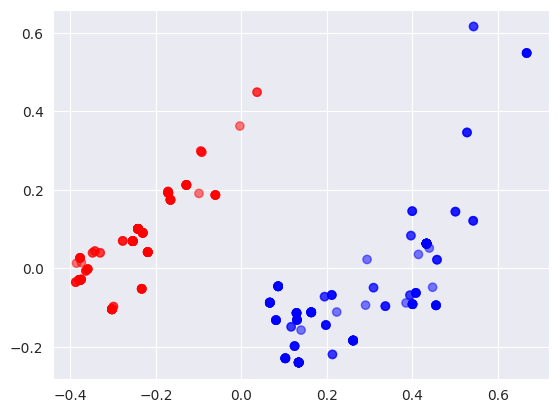

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.scatter([point[0] for point in points], [point[1] for point in points], c=['red' for i in range(len(A_s))] + ['blue' for i in range(len(B_s))], alpha=0.5)
plt.show()